In [4]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# Explore the data

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train_df.shape, test_df.shape

((42000, 785), (28000, 784))

We have 42000 training instances with 784 features (1 pixel = 1 feature) + the label column.

We also have 28000 testing instances without labels, used by Kaggle to evaluate and rank our model.

We will have to hold out a small percentage of the data from the training set for validation purposes.

In [8]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Checking class imbalance

In [9]:
label_counts = train_df.label.value_counts()
label_counts

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

**Although not all classes (each digit is one class) have the same amount of instances, they are all close to 4000.**

**This means no class is over- or underrepresented and the dataset is relatively balanced. It is safe to use accuracy as an evaluation metric.**

<Axes: xlabel='label', ylabel='Count'>

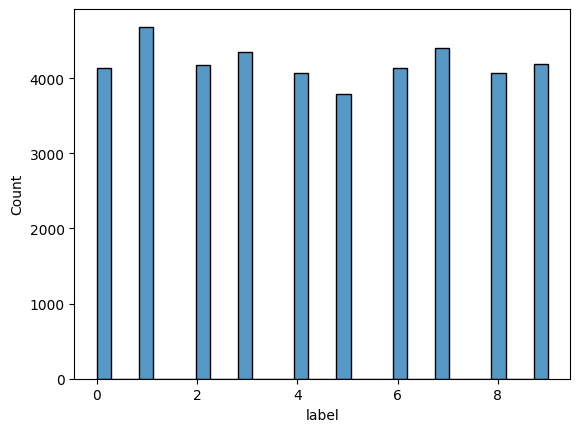

In [10]:
sns.histplot(x='label', data=train_df, bins='auto')

# Feed-forward NN model with Keras

In [23]:
from tensorflow import keras, convert_to_tensor
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

In [9]:
# Separate the label from training features
X = train_df.copy()
y = X.pop('label')

# Create a validation set from the training data for evaluation purposes
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, shuffle=True)

# Convert to tensor format for compatibility with Keras
X_train = convert_to_tensor(X_train)
X_valid = convert_to_tensor(X_valid)

# NNs work generally better when the input data is not spread out, but rather between 0 and 1
X_train /= 255
X_valid /= 255

# Convert target variable to tensor
y_train = convert_to_tensor(y_train)
y_valid = convert_to_tensor(y_valid)

# One-hot encoding to abide by the Keras API rules
y_train = np_utils.to_categorical(y_train, 10)
y_valid = np_utils.to_categorical(y_valid, 10)

In [12]:
# input_shape = [train_df.shape[1]-1]

# Build a feed-forward NN model with 3 hidden layers, batch normalization and dropout (to prevent overfitting)
model = keras.models.Sequential([
    # Having BatchNormalization() as the first layer generally removes the need for manual data normalization
    # The input layer has 784 neurons, one for each pixel (28x28 pixel images are flattened into a vector of length 784)
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, input_shape=(784,), activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dropout(0.3),
    
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dropout(0.3),
    
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dropout(0.3),
    
    # The output layer has 10 neurons -- one for each class (we have 10 digits)
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10, 
    restore_best_weights=True
)

history = model.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=500,
    callbacks=[early_stopping],
    validation_data=(X_valid, y_valid)
)

Epoch 1/500
1182/1182 [==============================] - 17s 13ms/step - loss: 0.4070 - accuracy: 0.8777 - val_loss: 0.1984 - val_accuracy: 0.9383
Epoch 2/500
1182/1182 [==============================] - 15s 12ms/step - loss: 0.2303 - accuracy: 0.9276 - val_loss: 0.1490 - val_accuracy: 0.9562
Epoch 3/500
1182/1182 [==============================] - 14s 12ms/step - loss: 0.1798 - accuracy: 0.9438 - val_loss: 0.1445 - val_accuracy: 0.9576
Epoch 4/500
1182/1182 [==============================] - 14s 12ms/step - loss: 0.1546 - accuracy: 0.9510 - val_loss: 0.1221 - val_accuracy: 0.9643
Epoch 5/500
1182/1182 [==============================] - 15s 12ms/step - loss: 0.1371 - accuracy: 0.9571 - val_loss: 0.1072 - val_accuracy: 0.9690
Epoch 6/500
1182/1182 [==============================] - 14s 12ms/step - loss: 0.1187 - accuracy: 0.9616 - val_loss: 0.1095 - val_accuracy: 0.9681
Epoch 7/500
1182/1182 [==============================] - 15s 12ms/step - loss: 0.1045 - accuracy: 0.9665 - val_loss: 0

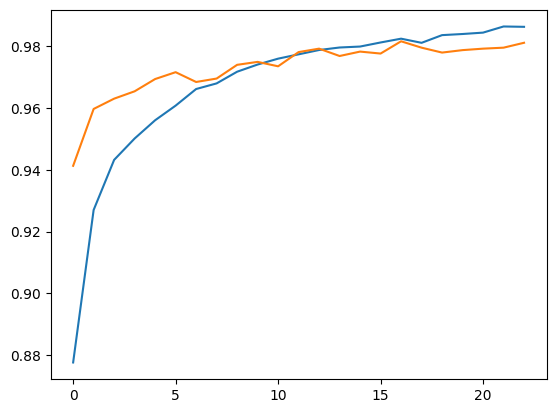

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

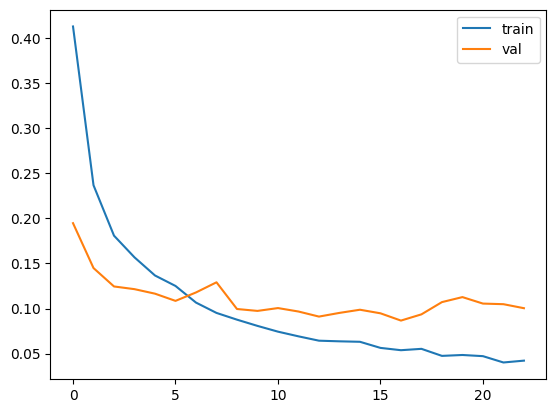

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper right')

### Predictions for submission

In [31]:
import tensorflow as tf

X_test = test_df.values
X_test = X_test.reshape(X_test.shape[0], 784, 1) / 255
y_test_pred = model.predict(X_test)

875/875 [==============================] - 3s 4ms/step


In [32]:
y_test_pred_labels = np.array([np.argmax(y) for y in y_test_pred])
len(y_test_pred_labels)

28000

In [33]:
result = pd.DataFrame(np.c_[np.arange(1, len(y_test_pred_labels) + 1), y_test_pred_labels], columns = ['ImageId', 'Label'])
result.to_csv('submission_3.csv', index = False)

# CNN with PyTorch
**Convolution NNs generally yield better results for unstructured data like images**

In [69]:
import torch
import torch.nn as nn

In [70]:
# Use a GPU, if available, for faster computations
# Speed improvement might not be noticeable due to the small dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [71]:
# Custom function to calculate accuracy
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [72]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device) -> dict:
  
  """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.


    Returns:
        (dict): Results of model making predictions on data_loader.
    """

    loss, acc = 0, 0
    model.eval()

    # use inference_mode() to not keep track of the gradients
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))
      
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}


In [73]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device) -> tuple:
    """
    A custom training step for the NN. It will be called once per batch.
    
    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.


    Returns:
        (tensor, float): Loss and accuracy for the training part.
    """
  
    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU, if available
        X, y = X.to(device), y.to(device)

        model.train()
        y_pred = model(X)

        loss = loss_fn(y_pred, y.long())
        train_loss += loss

        acc = accuracy_fn(y_true=y,
                          y_pred=y_pred.argmax(dim=1))
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device) -> tupe:
    
    """
    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.


    Returns:
        (tensor, float): Loss and accuracy for the testing part
    """
  
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            loss = loss_fn(test_pred, y.long())
            test_loss += loss

            acc = accuracy_fn(y_true=y,
                            y_pred=test_pred.argmax(dim=1))
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracybatch_sampler: {test_acc:.2f}%\n")
    
    return test_loss, test_acc


In [74]:
# Create the structure of the Convolutional Neural Network
class DigitRecognizerCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
  
    # Every model should have the forward method
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


In [75]:
torch.manual_seed(42)

# Initialize the class (model)
model_2 = DigitRecognizerCNN(input_shape=1,
                              hidden_units=20,
                              output_shape=len(label_counts)).to(device)
model_2                      

DigitRecognizerCNN(
  (block_1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=980, out_features=10, bias=True)
  )
)

In [76]:
# Use softmax as a loss function, since we have a multiclass classification problem
loss_fn = nn.CrossEntropyLoss()

# Use stochastic gradient descent as an optimizer with a learning rate of 0.1
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [77]:
from sklearn.model_selection import train_test_split

# Perform the same operations as done earlier with Keras, but this time with PyTorch

X_train = train_df.copy()
y_train = X_train.pop('label')

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True)

X_train = torch.tensor(X_train.values, dtype=torch.float)
X_valid = torch.tensor(X_valid.values, dtype=torch.float)

X_train /= 255
X_valid /= 255

y_train = torch.tensor(y_train.values, dtype=torch.int)
y_valid = torch.tensor(y_valid.values, dtype=torch.int)

In [109]:
X_train.shape

torch.Size([37800, 784])

In [110]:
final_train_set.shape

torch.Size([42000, 784])

In [79]:
# put the data in a list of tuples (tensor of training features, tensor of label)

train_data = []
for i in range(len(X_train)):
   train_data.append([X_train[i].reshape(1, 28, 28), y_train[i]])

test_data = []
for i in range(len(X_valid)):
   test_data.append([X_valid[i].reshape(1, 28, 28), y_valid[i]])

Image shape: torch.Size([1, 28, 28])
Image shape: torch.Size([28, 28])


Text(0.5, 1.0, 'tensor(8, dtype=torch.int32)')

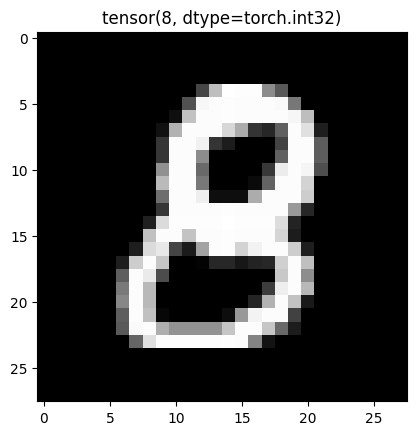

In [80]:
import matplotlib.pyplot as plt
image, label = test_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.reshape(28, 28), cmap='gray')
print(f"Image shape: {image.reshape(28, 28).shape}")
plt.title(label)


In [81]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False
                             )


print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} = {len(train_dataloader)*BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} = {len(test_dataloader)*BATCH_SIZE}")

Length of train dataloader: 1182 batches of 32 = 37824
Length of test dataloader: 132 batches of 32 = 4224


In [82]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [83]:
test_features_batch, test_labels_batch = next(iter(test_dataloader))
test_features_batch.shape, test_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [101]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
early_stopper = EarlyStopper(patience=3, min_delta=0.001)


In [103]:
torch.manual_seed(42)

total_train_loss, total_train_acc = [], []
total_test_loss, total_test_acc = [], []

best_acc = 0
best_model = None

# Train and test model 
epochs = 50
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_results = train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
    total_train_loss.append(train_results[0].item())
    total_train_acc.append(train_results[1])
    
    val_results = test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
    total_test_loss.append(val_results[0].item())
    total_test_acc.append(val_results[1])
    
    if val_results[1] > best_acc:
        best_acc = val_results[1]
        best_model = model_2.state_dict()
    
    if early_stopper.early_stop(val_results[0]):             
        break

Epoch: 0
---------
Train loss: 0.00837 | Train accuracy: 99.71%
Test loss: 0.06926 | Test accuracybatch_sampler: 98.48%

Epoch: 1
---------
Train loss: 0.00927 | Train accuracy: 99.72%
Test loss: 0.05734 | Test accuracybatch_sampler: 98.82%

Epoch: 2
---------
Train loss: 0.00922 | Train accuracy: 99.70%
Test loss: 0.05227 | Test accuracybatch_sampler: 98.77%

Epoch: 3
---------
Train loss: 0.00795 | Train accuracy: 99.72%
Test loss: 0.06805 | Test accuracybatch_sampler: 98.56%

Epoch: 4
---------
Train loss: 0.00839 | Train accuracy: 99.69%
Test loss: 0.07180 | Test accuracybatch_sampler: 98.77%

Epoch: 5
---------
Train loss: 0.00786 | Train accuracy: 99.71%
Test loss: 0.06009 | Test accuracybatch_sampler: 98.82%



### Plotting the loss

(0.0, 0.1)

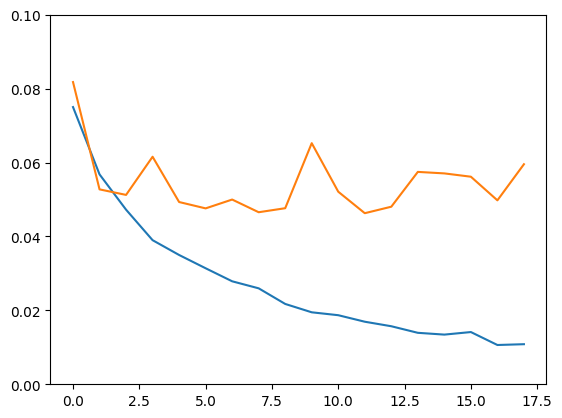

In [100]:
ax = plt.gca()

plt.plot(np.arange(0, len(total_train_loss)), total_train_loss)
plt.plot(np.arange(0, len(total_test_loss)), total_test_loss)

ax.set_ylim([0, 0.1])

### Plotting the accuracy

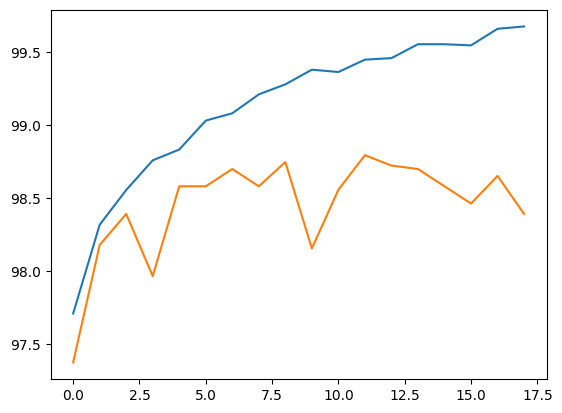

In [92]:
plt.plot(np.arange(0, len(total_train_acc)), total_train_acc)
plt.plot(np.arange(0, len(total_test_acc)), total_test_acc)

# Train the best model on training + validation data one last time

In [119]:
final_model = DigitRecognizerCNN(input_shape=1, hidden_units=20, output_shape=len(label_counts)).to(device)
final_model.load_state_dict(best_model)


train_step(data_loader=final_dataloader, 
        model=final_model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

Train loss: 0.00982 | Train accuracy: 99.75%


(tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>), 99.75247524752476)

In [ ]:
# Join the training set and the validation set for a final round of training
# This time, we do not evaluate the model because we don't have any testing data left
# This will be the final model

final_train_set = torch.cat([X_train, X_valid], dim=0)
final_labels = torch.cat([y_train, y_valid], dim=0)

final_data = []
for i in range(len(final_train_set)):
    final_data.append([final_train_set[i].reshape(1, 28, 28), final_labels[i]])
    
final_dataloader = DataLoader(final_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True
                          )

## Predictions for Kaggle submission


In [121]:
import tensorflow as tf

X_test = torch.tensor(test_df.values, dtype=torch.float).to(device)

X_test = X_test.reshape(X_test.shape[0], 784, 1) / 255

y_preds = []

with torch.inference_mode():
    for X in X_test:
        y_pred = final_model(X.reshape(1, 1, 28, 28))
        y_preds.append(y_pred)

In [124]:
y_test_pred_labels = np.array([np.argmax(y.cpu()) for y in y_preds])
len(y_test_pred_labels)

28000

In [125]:
result = pd.DataFrame(np.c_[np.arange(1, len(y_test_pred_labels) + 1), y_test_pred_labels], columns = ['ImageId', 'Label'])
result.to_csv('submission_5.csv', index = False)

# Result

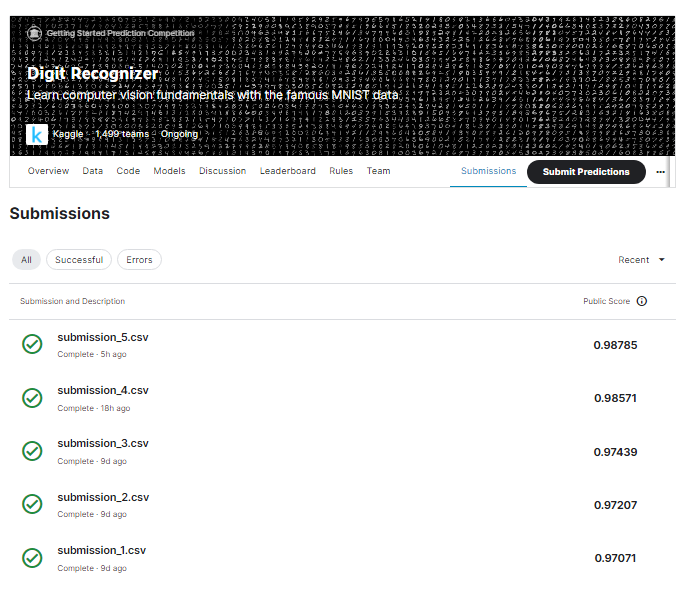

### The CNN model trained one final time with all of the data scored the highest, ~0.9879 accuracy.
### The CNN model without training on the validation data in the end scored lower, ~0.9857 accuracy.
### The feed-forward neural networks scored lower, with the best score being ~0.9744.